In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

2025-03-28 18:59:13.576093: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 18:59:13.578578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 18:59:13.586575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743202753.599922    8016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743202753.604712    8016 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743202753.614733    8016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
symbol = 'EUR='

In [3]:
data = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [4]:
data.rename(columns={symbol: 'price'}, inplace=True)


In [5]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [6]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [7]:
lags = 5

In [8]:
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [9]:
data.round(4).tail()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,price,XAU=,GDX,GLD,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,,,,,,,,,
2019-12-24,284.27,157.38,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,289.91,158.67,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,289.80,158.96,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,291.52,157.59,59.62,1846.89,229.80,321.08,3221.29,14.82,1.1197,1515.1230,29.49,142.63,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,293.65,157.70,59.85,1847.84,229.93,321.86,3230.78,13.78,1.1210,1517.0100,29.28,142.90,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [10]:
optimizer = Adam(learning_rate=0.0001)

E0000 00:00:1743202756.632557    8016 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743202756.632806    8016 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [12]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
cutoff = '2017-12-31'

In [14]:
training_data = data[data.index < cutoff].copy()

In [15]:
mu, std = training_data.mean(), training_data.std()

In [16]:
training_data_ = (training_data - mu) / std

In [17]:
test_data = data[data.index >= cutoff].copy()

In [18]:
test_data_ = (test_data - mu) / std

In [19]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 9.46 s, sys: 2.13 s, total: 11.6 s
Wall time: 6.98 s


In [20]:
res = pd.DataFrame(model.history.history)

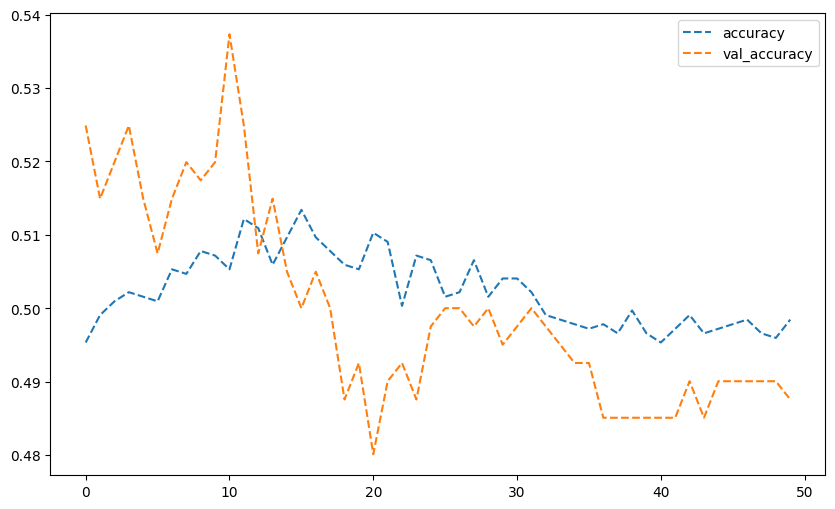

In [21]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [22]:
model.evaluate(training_data_[cols], training_data['direction'])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5218 - loss: 0.8561  


[0.8378749489784241, 0.5181863307952881]

In [23]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [24]:
pred[:30].flatten()


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
training_data['prediction'] = np.where(pred > 0, 1, -1)


In [26]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [27]:
training_data[['return', 'strategy']].sum().apply(np.exp)


return      0.826569
strategy    1.074617
dtype: float64

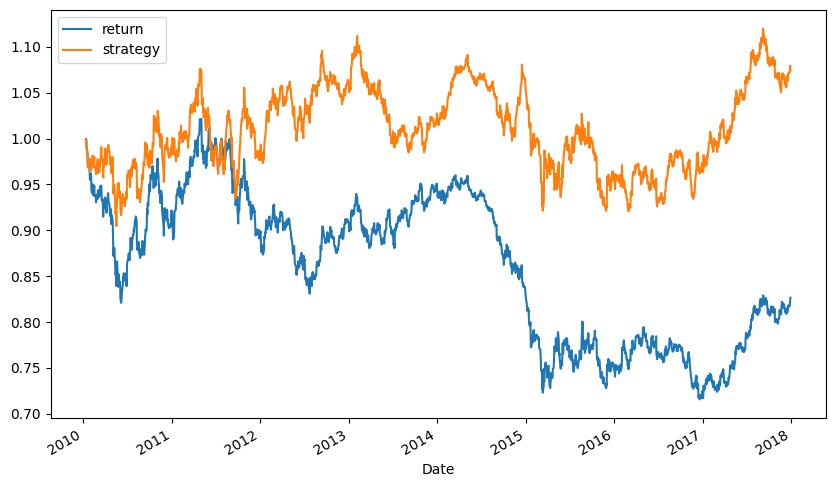

In [28]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [29]:
model.evaluate(test_data_[cols], test_data['direction'])


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4755 - loss: 0.7952 


[0.7941958904266357, 0.4572564661502838]

In [30]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [31]:
test_data['prediction'] = np.where(pred > 0, 1, -1)


In [32]:
test_data['prediction'].value_counts()


prediction
 1    403
-1    100
Name: count, dtype: int64

In [33]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [34]:
test_data[['return', 'strategy']].sum().apply(np.exp)


return      0.934478
strategy    0.880805
dtype: float64

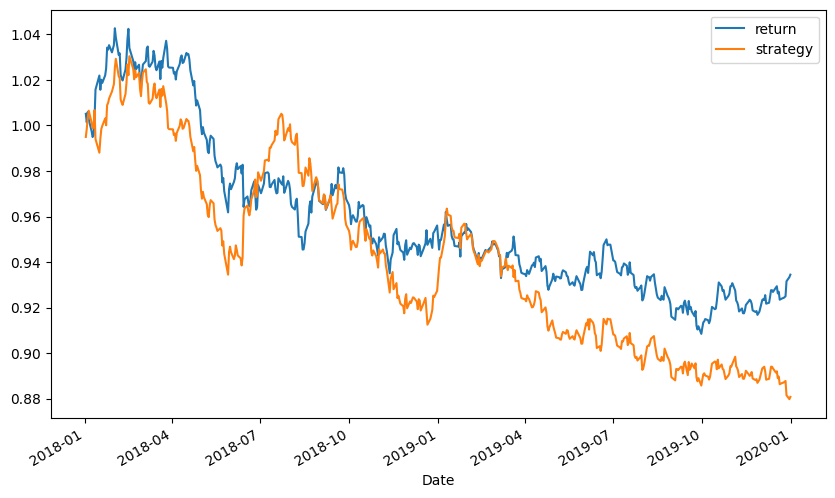

In [35]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

## Adding Additional Features

In [36]:
# So far analysis has only focussed on log returns
# We can add more classes / categories as well as more features to categorize with
# ie - momentum, volitality, distance

In [37]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)
# calculates the momentum by taking the prev 5 days and getting the average in log returns, applied to the next day

In [38]:
data['volatility'] = data['return'].rolling(20).std().shift(1)
# calculates the volatility by taking the stadnard deviation of the log returns of last 20 days, applied to the next day

In [39]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
# calculates the distance by determining the current days price minus the 50 day moving average, applied to the next day

In [40]:
data.dropna(inplace=True)

In [41]:
data[['momentum', 'volatility', 'distance']].head()

,momentum,volatility,distance
Date,,,
2010-03-25,-0.006270,0.005960,-0.048112
2010-03-26,-0.004880,0.005940,-0.049180
2010-03-29,-0.001797,0.006284,-0.033780
2010-03-30,-0.001154,0.006337,-0.025030
2010-03-31,-0.001293,0.006359,-0.029688


In [42]:
cols.extend(['momentum', 'volatility', 'distance'])

In [43]:
data.round(4).tail()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,price,XAU=,...,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,284.27,157.38,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,...,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006,-0.0010,0.0024,0.0005
2019-12-26,289.91,158.67,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,...,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034,-0.0011,0.0024,0.0004
2019-12-27,289.80,158.96,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,...,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008,-0.0003,0.0024,0.0012
2019-12-30,291.52,157.59,59.62,1846.89,229.80,321.08,3221.29,14.82,1.1197,1515.1230,...,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038,0.0010,0.0028,0.0089
2019-12-31,293.65,157.70,59.85,1847.84,229.93,321.86,3230.78,13.78,1.1210,1517.0100,...,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007,0.0021,0.0028,0.0110


In [44]:
# Redefine the test and training set
# normalize the features
# update model to reflect the new features

training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

In [45]:
test_data = data[data.index >= cutoff].copy()

In [46]:
test_data_ = (test_data - mu) / std

In [57]:
set_seeds()
optimizer = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
# train the classifier with the new features
tf.config.run_functions_eagerly(True)

In [59]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


CPU times: user 32.6 s, sys: 291 ms, total: 32.9 s
Wall time: 32.1 s


In [60]:
model.evaluate(training_data_[cols], training_data['direction'])

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5312 - loss: 0.6887

/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5392 - loss: 0.6860


[0.6852320432662964, 0.5426673293113708]

In [61]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [62]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [63]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [64]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    2.483560
dtype: float64

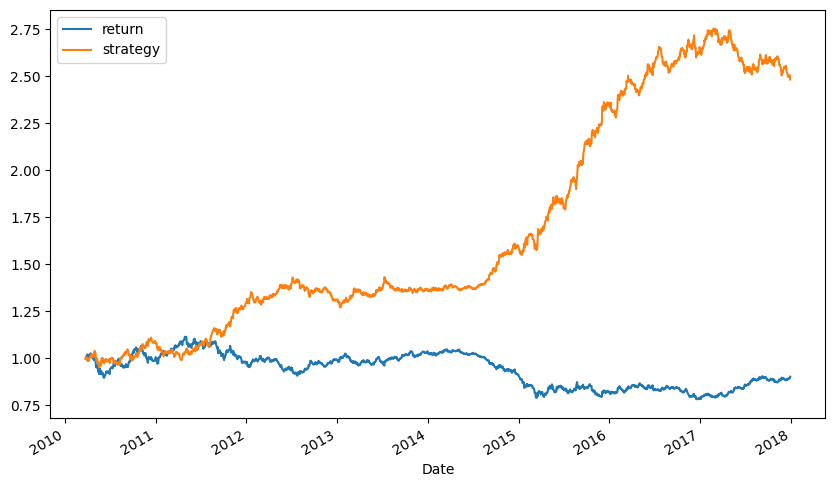

In [65]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

In [66]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5192 - loss: 0.6924


/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[0.6920908689498901, 0.5188866853713989]

In [67]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [69]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [70]:
test_data['prediction'].value_counts()

prediction
-1    361
 1    142
Name: count, dtype: int64

In [71]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [72]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.135347
dtype: float64

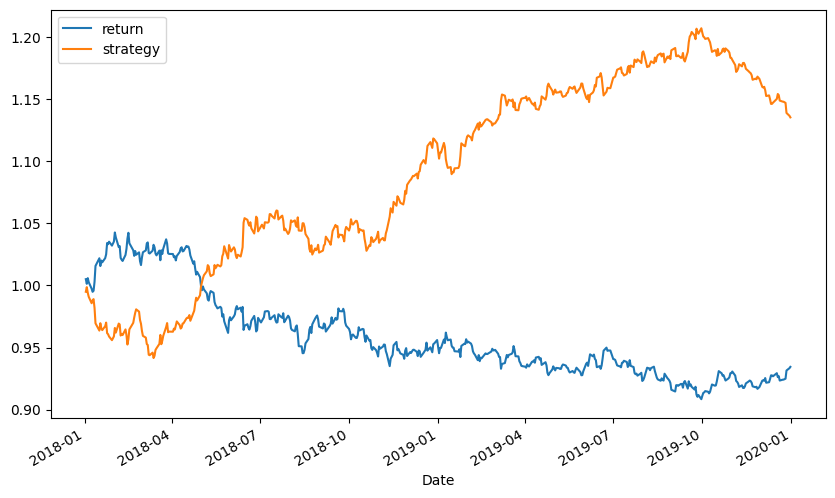

In [73]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));